<a href="https://colab.research.google.com/github/NeuromatchAcademy/course-content-dl/blob/main/projects/Neuroscience/cellular_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> &nbsp; <a href="https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content-dl/main/projects/Neuroscience/cellular_segmentation.ipynb" target="_parent"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Open in Kaggle"/></a>

# Segmentation and Denoising

**By Neuromatch Academy**

__Content creators:__ Carsen Stringer

__Produtction editors:__ Spiros Chavlis

---
# Objective

This notebook will give you starting points to perform
* cellular segmentation using cultured neurons (outside the brain)
* analysis of neuronal activity in calcium imaging experiments such as finding cells, denoising data and predicting activity

---
# Setup

In [1]:
# @title Install dependencies
!pip install opencv-python --quiet
!pip install numba --quiet
!pip install tifffile --quiet

In [2]:
# Imports
import os
import cv2
import tqdm
import hashlib
import requests

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from numba import jit

from scipy.ndimage import gaussian_filter
from scipy.ndimage import find_objects, binary_fill_holes
from scipy.ndimage import generate_binary_structure, label
from scipy.optimize import linear_sum_assignment

---
# Intro to segmentation + denoising

## Segmentation

To answer many biological questions, it is necessary to segment the individual cells in images. Segmentation allows 
* computation of number of cells in an image, useful for instance to compare the effects of drugs on cell survival
* accurate estimation of cell shapes, also useful for the same reasons
* temporal measurements of cellular dynamics such as cell division, cellular movements or calcium influx
* quantification of protein or RNA expresssion

The first part of this notebook will set up a basic [U-net](https://arxiv.org/abs/1505.04597) convolutional network to do cellular segmentation using a curated version of this [dataset](http://www.cellimagelibrary.org/images/CCDB_6843), which the first cell of the notebook will download for you. These are images with a cytoplasm stain (whole cell stained) and a nuclear stain (channels 1 and 2 of the images). The segmentation masks provided are for the cytoplasm (whole cell segmentation). There is code to train and test the network with a simple cost function.

<img src="https://raw.githubusercontent.com/NeuromatchAcademy/course-content-dl/main/projects/static/cellular_segmentation_image.png">


Can you do transfer learning with this network on new images? There are image labels for other [datasets](https://bbbc.broadinstitute.org/image_sets) for instance provided by Anne Carpenter's lab at the Broad. Maybe your cellular segmenter can work on [worms](https://bbbc.broadinstitute.org/BBBC010) or a herd of bison! Note that the network is learning the approximate sizes of objects, so you may need to rescale other images accordingly. To label new images you may need to use a tool like [napari](https://www.napari.org).

<img src="https://raw.githubusercontent.com/NeuromatchAcademy/course-content-dl/main/projects/static/bison.3.600.jpg">


**Note**: The data provided consists of both a training and a test set. It is important to not overfit to the test set, and only use it for a final evaluation. This code splits the training set into a training and a validation data set. Use this split data for testing out different algorithms. Then, after you finish developing your algorithm you can evaluate it on the test data.

## Analysis of neural activity data

Often in neuroscience we have temporal data which consists of a movie of neuronal activity recorded using a microscope. Processing these movies can require several steps. We will focus on the neural detection step because that is a problem that we can use convolutional networks to help us with. The second part of this notebook therefore applies the model from the first part to the maximum image of the neural movie. This detects some neurons in the recording. Could we detect more neurons though if we denoise the movie first? Also what happens if we use more information across frames to detect cells? You may also want to explore denoising neural data from other sources (see other curated datasets in the NMA projects folder). None of these approaches are implemented here so this is a more open-ended project. 

* imaging data loaded in [suite2p](https://github.com/mouseland/suite2p)

<img src="https://raw.githubusercontent.com/NeuromatchAcademy/course-content-dl/main/projects/static/multiselect_cellular.gif">


Acknowledgments:
This Notebook was developed by Carsen Stringer. It borrows from:
* [cellpose](https://github.com/mouseland/cellpose) (written by Carsen Stringer and Marius Pachitariu)
* Kristin Branson's PoseEstimation notebook

---
# Segmenting neurons in a dish

## Data loading

In [3]:
# @title Download and normalize data
filenames = ["cells_train.npz",
             "cells_test.npz"]
urls = ["https://osf.io/z3h78/download",
        "https://osf.io/ft5p3/download"]
expected_md5s = ["85e1fe2ee8d936c1083d62563d79d958",
                 "e8f789abe20a7efde806d9ba03d20fd7"]

for fname, url, expected_md5 in zip(filenames, urls, expected_md5s):
  if not os.path.isfile(fname):
    try:
      r = requests.get(url)
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      elif hashlib.md5(r.content).hexdigest() != expected_md5:
        print("!!! Data download appears corrupted !!!")
      else:
        with open(fname, "wb") as fid:
          fid.write(r.content)

cells_train = np.load('cells_train.npz', allow_pickle=True)['arr_0'].item()
cells_test = np.load('cells_test.npz', allow_pickle=True)['arr_0'].item()
imgs_train = np.array(cells_train['imgs']).transpose(0, 3, 1, 2)
masks_train = np.array(cells_train['masks'])
imgs_test = np.array(cells_test['imgs']).transpose(0, 3, 1, 2)
masks_test = np.array(cells_test['masks'])

# we are going to normalize the images so their pixel values mostly fall between 0 and 1
# this is helpful if you have images on a variety of scales
# we will also return the images as float32 <- the data type that is fast for GPU computation
def normalize99(img):
  """ normalize image so 0.0 is 1st percentile and 1.0 is 99th percentile """
  X = img.copy()
  x01 = np.percentile(X, 1)
  x99 = np.percentile(X, 99)
  X = (X - x01) / (x99 - x01)
  return X.astype(np.float32)


imgs_train = np.array([normalize99(img) for img in imgs_train])
imgs_test = np.array([normalize99(img) for img in imgs_test])

Plot a random training image and its masks. Note the masks are labels from 1, ... to the number of cells.

there are 45 cells in this image


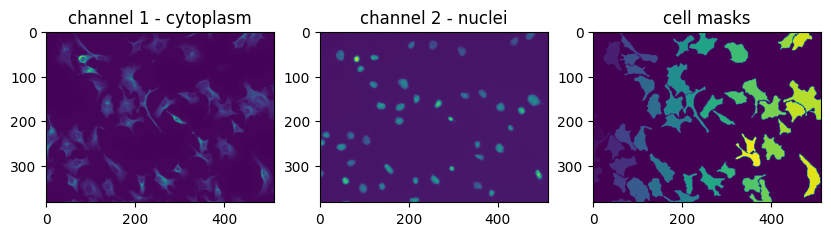

In [4]:
irand = np.random.randint(len(imgs_train))

plt.figure(figsize=(10, 4))
plt.subplot(1, 3, 1)
plt.imshow(imgs_train[irand][0])
plt.title('channel 1 - cytoplasm')

plt.subplot(1, 3, 2)
plt.imshow(imgs_train[irand][1])
plt.title('channel 2 - nuclei')

plt.subplot(1, 3, 3)
plt.imshow(masks_train[irand])
plt.title('cell masks')
print(f'there are {masks_train[irand].max()} cells in this image')
plt.show()

What labels will we use? We can't use numbers like masks.
The standard approach is to create a "not-cell" and a "cell" probability map for the network to learn. Then this map is thresholded (the threshold is found with a validation set) to find cells.


In [5]:
labels_train = np.zeros((len(masks_train), 2,
                         masks_train.shape[-2],
                         masks_train.shape[-1]),
                        np.longlong)
labels_train[:, 0] = masks_train == 0
labels_train[:, 1] = masks_train > 0

labels_test = np.zeros((len(masks_test), 2,
                        masks_test.shape[-2],
                        masks_test.shape[-1]),
                       np.longlong)
labels_test[:, 0] = masks_test == 0
labels_test[:, 1] = masks_test > 0

## Create transform function for augmentations

adapted from [cellpose/transforms.py](https://github.com/MouseLand/cellpose/blob/master/cellpose/transforms.py).

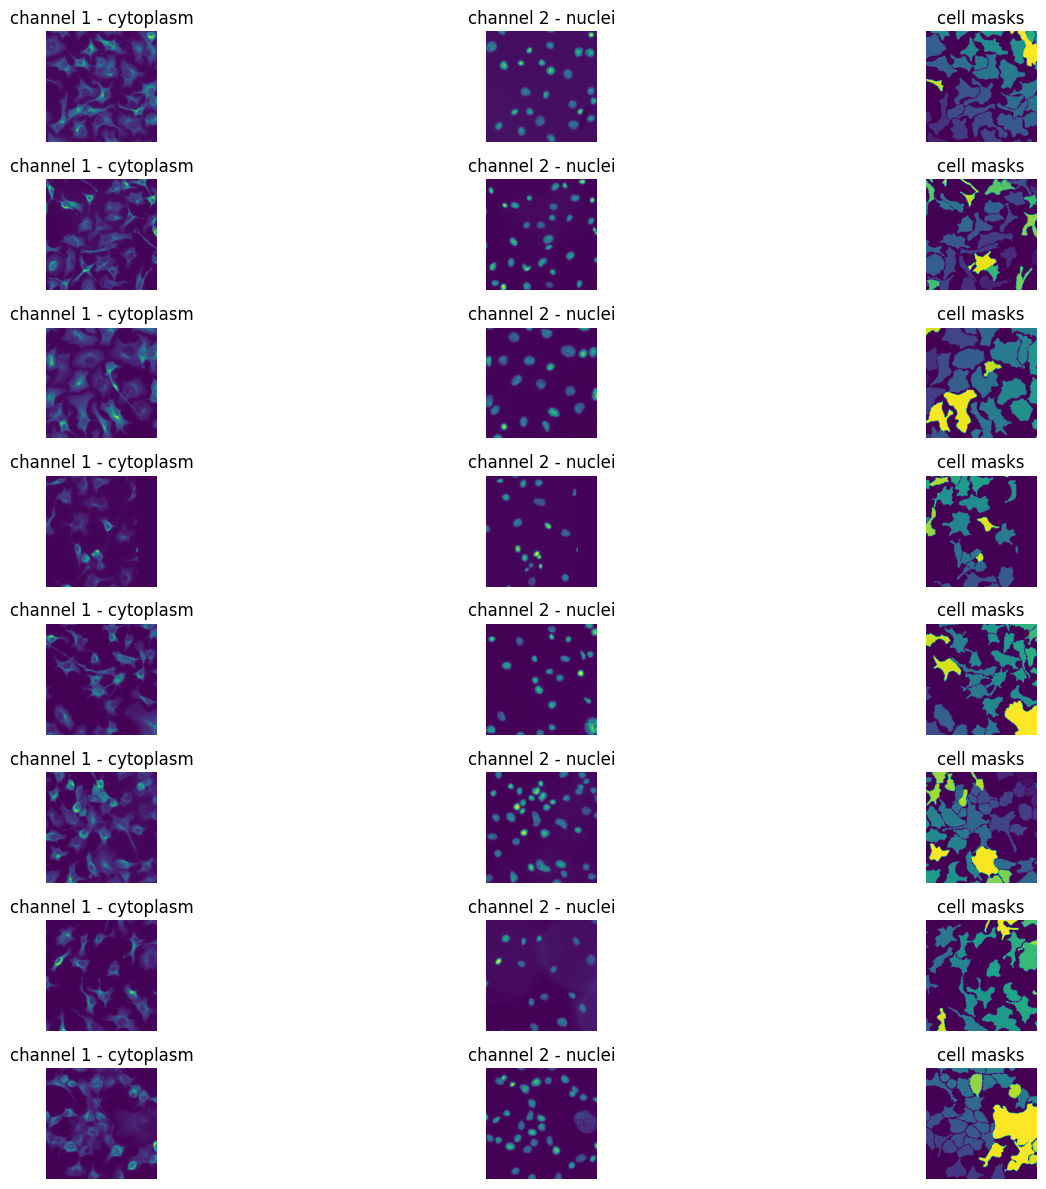

In [6]:
def random_rotate_and_resize(X, Y=None, scale_range=0.5, xy=(224, 224),
                             do_flip=True):
  """
  Augmentation by random rotation and resizing

  X and Y are lists or arrays of length nimg, with dims channels x Ly x Lx (channels optional)

  Parameters
  ----------
  X: ND-array, float
    list of IMAGE arrays of size [nchan x Ly x Lx] or [Ly x Lx]

  Y: ND-array, float or int (optional, default None)
    list of MASK arrays of size [nlabels x Ly x Lx] or [Ly x Lx].
    ** These labels are nearest neighbor interpolated
    ** CHANGE IF USING FLOAT LABELS

  scale_range: float (optional, default 1.0)
    Range of resizing of images for augmentation. Images are resized by
    (1-scale_range/2) + scale_range * np.random.rand()

  xy: tuple, int (optional, default (224,224))
    size of transformed images to return

  do_flip: bool (optional, default True)
    whether or not to flip images horizontally

  Returns
  -------
  imgi: ND-array, float
    transformed images in array [nimg x nchan x xy[0] x xy[1]]

  lbl: ND-array, float
    transformed labels in array [nimg x nchan x xy[0] x xy[1]]

  scale: array, float
    amount each image was resized by
  """

  scale_range = max(0, min(2, float(scale_range)))
  nimg = len(X)
  if X[0].ndim > 2:
    nchan = X[0].shape[0]
  else:
    nchan = 1
  imgi  = np.zeros((nimg, nchan, xy[0], xy[1]), np.float32)

  lbl = []
  if Y is not None:
    if Y[0].ndim > 2:
      nt = Y[0].shape[0]
    else:
      nt = 1
    lbl = np.zeros((nimg, nt, xy[0], xy[1]), Y.dtype)

  scale = np.zeros(nimg, np.float32)
  for n in range(nimg):
    Ly, Lx = X[n].shape[-2:]

    # generate random augmentation parameters
    flip = np.random.rand() > .5
    theta = np.random.rand() * np.pi * 2
    scale[n] = (1 - scale_range / 2) + scale_range * np.random.rand()
    dxy = np.maximum(0, np.array([Lx*scale[n] - xy[1], Ly * scale[n] - xy[0]]))
    dxy = (np.random.rand(2,) - .5) * dxy

    # create affine transform
    cc = np.array([Lx / 2, Ly / 2])
    cc1 = cc - np.array([Lx - xy[1], Ly - xy[0]]) / 2 + dxy
    pts1 = np.float32([cc, cc + np.array([1, 0]), cc + np.array([0, 1])])
    pts2 = np.float32([cc1,
            cc1 + scale[n]*np.array([np.cos(theta), np.sin(theta)]),
            cc1 + scale[n]*np.array([np.cos(np.pi/2 + theta),
                                     np.sin(np.pi/2 + theta)])])

    M = cv2.getAffineTransform(pts1, pts2)

    img = X[n].copy()
    if Y is not None:
      labels = Y[n].copy()
      if labels.ndim < 3:
        labels = labels[np.newaxis, :, :]

    if flip and do_flip:
      img = img[..., ::-1]
      if Y is not None:
        labels = labels[..., ::-1]

    for k in range(nchan):
      I = cv2.warpAffine(img[k], M, (xy[1], xy[0]), flags=cv2.INTER_LINEAR)
      imgi[n,k] = I

    if Y is not None:
      for k in range(nt):
        # ** nearest neighbor interpolation **
        # may need to change for float labels
        lbl[n,k] = cv2.warpAffine(labels[k], M, (xy[1], xy[0]),
                                  flags=cv2.INTER_NEAREST)

  return imgi, lbl, scale


img_batch, lbl_batch, scale = random_rotate_and_resize(imgs_train[:8],
                                                       masks_train[:8])

plt.figure(figsize=(16, 12))
for j in range(8):
  plt.subplot(8, 3, 3*j + 1)
  plt.imshow(img_batch[j, 0])
  plt.title('channel 1 - cytoplasm')
  plt.axis('off')

  plt.subplot(8, 3, 3*j + 2)
  plt.imshow(img_batch[j, 1])
  plt.title('channel 2 - nuclei')
  plt.axis('off')

  plt.subplot(8, 3, 3*j + 3)
  plt.imshow(lbl_batch[j, 0])
  plt.title('cell masks')
  plt.axis('off')
plt.tight_layout()
plt.show()

## Model architecture (u-net)

A u-net is commonly used for biological image segmentation because its shape allows for local and global features to be combined to create highly-precise segmentations.

A u-net is shaped like an autoencoder, it has:
1. a standard convolutional network with downsampling, like one used for imagenet
2. upsampling layers that ultimately return an image at the same size as the input image
In addition to these downsampling and upsampling blocks, it has skip connections from the downsampling blocks TO the upsampling blocks, which allows it to propagate more precise local information to the later layers.

adapted from [cellpose/resnet_torch.py](https://github.com/MouseLand/cellpose/blob/master/cellpose/resnet_torch.py).


In [7]:
def convbatchrelu(in_channels, out_channels, sz):
  return nn.Sequential(
      nn.Conv2d(in_channels, out_channels, sz, padding=sz//2),
      nn.BatchNorm2d(out_channels, eps=1e-5),
      nn.ReLU(inplace=True),
      )


class convdown(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size):
    super().__init__()
    self.conv = nn.Sequential()
    for t in range(2):
      if t == 0:
        self.conv.add_module('conv_%d'%t,
                             convbatchrelu(in_channels,
                                           out_channels,
                                           kernel_size))
      else:
        self.conv.add_module('conv_%d'%t,
                             convbatchrelu(out_channels,
                                           out_channels,
                                           kernel_size))

  def forward(self, x):
    x = self.conv[0](x)
    x = self.conv[1](x)
    return x


class downsample(nn.Module):
  def __init__(self, nbase, kernel_size):
    super().__init__()
    self.down = nn.Sequential()
    self.maxpool = nn.MaxPool2d(2, 2)
    for n in range(len(nbase) - 1):
      self.down.add_module('conv_down_%d'%n,
                           convdown(nbase[n],
                                    nbase[n + 1],
                                    kernel_size))

  def forward(self, x):
    xd = []
    for n in range(len(self.down)):
      if n > 0:
        y = self.maxpool(xd[n - 1])
      else:
        y = x
      xd.append(self.down[n](y))
    return xd


class convup(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size):
    super().__init__()
    self.conv = nn.Sequential()
    self.conv.add_module('conv_0', convbatchrelu(in_channels,
                                                 out_channels,
                                                 kernel_size))
    self.conv.add_module('conv_1', convbatchrelu(out_channels,
                                                 out_channels,
                                                 kernel_size))

  def forward(self, x, y):
    x = self.conv[0](x)
    x = self.conv[1](x + y)
    return x


class upsample(nn.Module):
  def __init__(self, nbase, kernel_size):
    super().__init__()
    self.upsampling = nn.Upsample(scale_factor=2, mode='nearest')
    self.up = nn.Sequential()
    for n in range(len(nbase) - 1 , 0, -1):
      self.up.add_module('conv_up_%d'%(n - 1),
              convup(nbase[n], nbase[n - 1], kernel_size))

  def forward(self, xd):
    x = xd[-1]
    for n in range(0, len(self.up)):
      if n > 0:
        x = self.upsampling(x)
      x = self.up[n](x, xd[len(xd) - 1 - n])
    return x


class Unet(nn.Module):
  def __init__(self, nbase, nout, kernel_size):
    super(Unet, self).__init__()
    self.nbase = nbase
    self.nout = nout
    self.kernel_size = kernel_size
    self.downsample = downsample(nbase, kernel_size)
    nbaseup = nbase[1:]
    nbaseup.append(nbase[-1])
    self.upsample = upsample(nbaseup, kernel_size)
    self.output = nn.Conv2d(nbase[1], self.nout, kernel_size,
                            padding=kernel_size//2)

  def forward(self, data):
    T0 = self.downsample(data)
    T0 = self.upsample(T0)
    T0 = self.output(T0)
    return T0

  def save_model(self, filename):
    torch.save(self.state_dict(), filename)

  def load_model(self, filename, cpu=False):
    if not cpu:
      self.load_state_dict(torch.load(filename))
    else:
      self.__init__(self.nbase,
                    self.nout,
                    self.kernel_size,
                    self.concatenation)

      self.load_state_dict(torch.load(filename,
                                      map_location=torch.device('cpu')))

### Define the network

In [8]:
kernel_size = 3
nbase = [2, 32, 64, 128, 256]  # number of channels per layer
nout = 2  # number of outputs

net = Unet(nbase, nout, kernel_size)
# put on GPU here if you have it
device = 'cuda' if torch.cuda.is_available() else 'cpu'
net.to(device);  # remove semi-colon to see net structure

### Train the network

Here we've implemented code to train the network.

Note we probably should be evaluating test performance throughout training -- implement that yourself.

In [9]:
from datetime import datetime

# train the network
# parameters related to training the network
batch_size = 8 # number of images per batch -- amount of required memory
              # for training will increase linearly in batchsize
### you will want to increase n_epochs!
n_epochs = 50  # number of times to cycle through all the data during training
learning_rate = 0.1 # initial learning rate
weight_decay = 1e-5 # L2 regularization of weights
momentum = 0.9 # how much to use previous gradient direction
n_epochs_per_save = 25 # how often to save the network
val_frac = 0.05 # what fraction of data to use for validation

# where to save the network
# make sure to clean these out every now and then, as you will run out of space
now = datetime.now()
timestamp = now.strftime('%Y%m%dT%H%M%S')

# split into train and validation datasets
n_val = int(len(imgs_train) * val_frac)
n_train = len(imgs_train) - n_val
np.random.seed(0)
iperm = np.random.permutation(len(imgs_train))
train_data, val_data = imgs_train[iperm[:n_train]], imgs_train[iperm[n_train:]]
train_labels, val_labels = labels_train[iperm[:n_train]], labels_train[iperm[n_train:]]
train_masks, val_masks = masks_train[iperm[:n_train]], masks_train[iperm[n_train:]]


# gradient descent flavor
optimizer = torch.optim.SGD(net.parameters(),
                            lr=learning_rate,
                            weight_decay=weight_decay,
                            momentum=0.9)
# set learning rate schedule
LR = np.linspace(0, learning_rate, 10)
if n_epochs > 250:
    LR = np.append(LR, learning_rate*np.ones(n_epochs-100))
    for i in range(10):
        LR = np.append(LR, LR[-1]/2 * np.ones(10))
else:
    LR = np.append(LR, learning_rate * np.ones(max(0, n_epochs - 10)))

criterion = nn.CrossEntropyLoss()

# store loss per epoch
epoch_losses = np.zeros(n_epochs)
epoch_losses[:] = np.nan

# when we last saved the network
saveepoch = None

# loop through entire training data set nepochs times
for epoch in range(n_epochs):
  net.train() # put in train mode (affects batchnorm)
  epoch_loss = 0
  iters = 0
  for param_group in optimizer.param_groups:
    param_group['lr'] = LR[epoch]
  with tqdm.tqdm(total=n_train, desc=f"Epoch {epoch + 1}/{n_epochs}", unit='img') as pbar:
    # loop through each batch in the training data
    for ibatch in np.arange(0, n_train, batch_size):
      # augment the data
      inds = np.arange(ibatch, min(n_train, ibatch+batch_size))
      train_data = train_data.astype(np.float32)
      train_labels = train_labels.astype(np.float32)
      imgs, lbls, _ = random_rotate_and_resize(train_data[inds],
                                               train_labels[inds])

      # transfer to torch + GPU
      imgs = torch.from_numpy(imgs).to(device=device)
      lbls = torch.from_numpy(lbls).to(device=device)
      lbls = lbls.long()

      # compute the loss
      y = net(imgs)
      loss = criterion(y, lbls[:, 1])
      epoch_loss += loss.item()
      pbar.set_postfix(**{'loss (batch)': loss.item()})
      # gradient descent
      optimizer.zero_grad()
      loss.backward()
      #nn.utils.clip_grad_value_(net.parameters(), 0.1)
      optimizer.step()
      iters+=1
      pbar.update(imgs.shape[0])

    epoch_losses[epoch] = epoch_loss
    pbar.set_postfix(**{'loss (epoch)': epoch_loss})  #.update('loss (epoch) = %f'%epoch_loss)

  # save checkpoint networks every now and then
  if epoch % n_epochs_per_save == 0:
    print(f"\nSaving network state at epoch {epoch+1}")
    saveepoch = epoch
    savefile = f"unet_epoch{saveepoch+1}.pth"
    net.save_model(savefile)
print(f"\nSaving network state at epoch {epoch+1}")
net.save_model(f"unet_epoch{epoch+1}.pth")

Epoch 1/50: 100%|████████████████████████████████████████████████████████████████████████████████████████| 77/77 [00:27<00:00,  2.81img/s, loss (epoch)=7.72]



Saving network state at epoch 1


Epoch 26/50: 100%|██████████████████████████████████████████████████████████████████████████████████████| 77/77 [00:26<00:00,  2.86img/s, loss (epoch)=0.933]



Saving network state at epoch 26


Epoch 50/50: 100%|███████████████████████████████████████████████████████████████████████████████████████| 77/77 [00:14<00:00,  5.33img/s, loss (epoch)=0.88]


Saving network state at epoch 50


### Test performance

Let's see how the network performs on a test image.

In [10]:
# @markdown Padding code for test images

def pad_image_ND(img0, div=16, extra=1):
  """ pad image for test-time so that its dimensions are a multiple of 16 (2D or 3D)

  Parameters
  -------------
  img0: ND-array
      image of size [nchan (x Lz) x Ly x Lx]
  div: int (optional, default 16)

  Returns
  --------------
  I: ND-array
      padded image
  slices: tuple, int
      range of pixels in I corresponding to img0
  """
  Lpad = int(div * np.ceil(img0.shape[-2] / div) - img0.shape[-2])
  xpad1 = extra * div//2 + Lpad//2
  xpad2 = extra * div//2 + Lpad - Lpad//2
  Lpad = int(div * np.ceil(img0.shape[-1] / div) - img0.shape[-1])
  ypad1 = extra * div//2 + Lpad//2
  ypad2 = extra * div//2 + Lpad - Lpad//2

  if img0.ndim > 3:
    pads = np.array([[0, 0], [0, 0], [xpad1, xpad2], [ypad1, ypad2]])
  else:
    pads = np.array([[0, 0], [xpad1, xpad2], [ypad1, ypad2]])

  I = np.pad(img0, pads, mode='constant')

  Ly, Lx = img0.shape[-2:]
  ysub = np.arange(xpad1, xpad1 + Ly)
  xsub = np.arange(ypad1, ypad1 + Lx)
  slc = [slice(0, img0.shape[n] + 1) for n in range(img0.ndim)]
  slc[-3] = slice(0, imgs.shape[-3] + 1)
  slc[-2] = slice(ysub[0], ysub[-1] + 1)
  slc[-1] = slice(xsub[0], xsub[-1] + 1)
  slc = tuple(slc)

  return I, slc

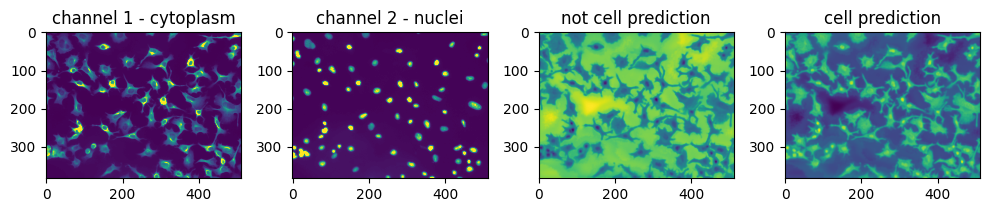

In [11]:
# compute results on test images
# (note for unet to run correctly we need to pad images to be divisible by 2**(number of layers))

net.eval()
img_padded, slices = pad_image_ND(imgs_test[0], 8)
img_torch = torch.from_numpy(img_padded).to(device).unsqueeze(0)  # also need to add a first dimension
out = net(img_torch)
labels = out[0][slices].detach().cpu()

plt.figure(figsize=(10, 4))
plt.subplot(1, 4, 1)
plt.imshow(imgs_test[0][0], vmin=0, vmax=1)
plt.title('channel 1 - cytoplasm')

plt.subplot(1, 4, 2)
plt.imshow(imgs_test[0][1], vmin=0, vmax=1)
plt.title('channel 2 - nuclei')

plt.subplot(1, 4, 3)
plt.imshow(labels[0])
plt.title('not cell prediction')

plt.subplot(1, 4, 4)
plt.imshow(labels[1])
plt.title('cell prediction')
plt.tight_layout()
plt.show()

### Setting threshold for finding cells

We have found areas of "not cell" and "cell". To create an instance segmentation we need to assign each pixel in a cell to a specific cell rather than a general class. To do this, we will need to find a threshold that produces the best segmentations on our validation set. How do we define a good segmentation? We can use a measure called intersection-over-union (IoU) and call a cell a good cell if it overlaps with a ground-truth cell with an IoU greater than some value. We have taken code from [cellpose/metrics.py] to do this. These functions are based on functions from [stardist], another neat algorithm I recommend checking out!

This code below computes the average precision (which you want to maximize) for a given threshold. You'll want to try several thresholds and choose one (probably coding up a loop over reasonable thresholds).

In [12]:
# @title Helper functions

# @markdown `fill_holes_and_remove_small_masks` function
def fill_holes_and_remove_small_masks(masks, min_size=15):
  """ fill holes in masks (2D/3D) and discard masks smaller than min_size (2D)

  fill holes in each mask using scipy.ndimage.morphology.binary_fill_holes

  Parameters
  ----------------
  masks: int, 2D or 3D array
      labelled masks, 0=NO masks; 1,2,...=mask labels,
      size [Ly x Lx] or [Lz x Ly x Lx]
  min_size: int (optional, default 15)
      minimum number of pixels per mask, can turn off with -1

  Returns
  ---------------
  masks: int, 2D or 3D array
      masks with holes filled and masks smaller than min_size removed,
      0=NO masks; 1,2,...=mask labels,
      size [Ly x Lx] or [Lz x Ly x Lx]
  """
  slices = find_objects(masks)
  j = 0
  for i,slc in enumerate(slices):
    if slc is not None:
      msk = masks[slc] == (i + 1)
      npix = msk.sum()
      if min_size > 0 and npix < min_size:
        masks[slc][msk] = 0
      else:
        if msk.ndim==3:
          for k in range(msk.shape[0]):
            msk[k] = binary_fill_holes(msk[k])
        else:
          msk = binary_fill_holes(msk)
        masks[slc][msk] = (j + 1)
        j += 1

  return masks


# @markdown `average_precision` function
def average_precision(masks_true, masks_pred, threshold=[0.5, 0.75, 0.9]):
  """ average precision estimation: AP = TP / (TP + FP + FN)

  This function is based heavily on the *fast* stardist matching functions
  (https://github.com/mpicbg-csbd/stardist/blob/master/stardist/matching.py)

  Parameters
  ------------
  masks_true: list of ND-arrays (int)
      where 0=NO masks; 1,2... are mask labels
  masks_pred: list of ND-arrays (int)
      ND-array (int) where 0=NO masks; 1,2... are mask labels

  Returns
  ------------
  ap: array [len(masks_true) x len(threshold)]
      average precision at thresholds
  tp: array [len(masks_true) x len(threshold)]
      number of true positives at thresholds
  fp: array [len(masks_true) x len(threshold)]
      number of false positives at thresholds
  fn: array [len(masks_true) x len(threshold)]
      number of false negatives at thresholds
  """
  if not isinstance(threshold, list) and not isinstance(threshold, np.ndarray):
    threshold = [threshold]
  ap  = np.zeros((len(masks_true), len(threshold)), np.float32)
  tp  = np.zeros((len(masks_true), len(threshold)), np.float32)
  fp  = np.zeros((len(masks_true), len(threshold)), np.float32)
  fn  = np.zeros((len(masks_true), len(threshold)), np.float32)
  n_true = np.array(list(map(np.max, masks_true)))
  n_pred = np.array(list(map(np.max, masks_pred)))
  for n in range(len(masks_true)):
    #_,mt = np.reshape(np.unique(masks_true[n], return_index=True), masks_pred[n].shape)
    if n_pred[n] > 0:
      iou = _intersection_over_union(masks_true[n], masks_pred[n])[1:, 1:]
      for k,th in enumerate(threshold):
        tp[n,k] = _true_positive(iou, th)
    fp[n] = n_pred[n] - tp[n]
    fn[n] = n_true[n] - tp[n]
    ap[n] = tp[n] / (tp[n] + fp[n] + fn[n])

  return ap, tp, fp, fn


@jit(nopython=True)
def _label_overlap(x, y):
  """ fast function to get pixel overlaps between masks in x and y

  Parameters
  ------------
  x: ND-array, int
      where 0=NO masks; 1,2... are mask labels
  y: ND-array, int
      where 0=NO masks; 1,2... are mask labels

  Returns
  ------------
  overlap: ND-array, int
      matrix of pixel overlaps of size [x.max()+1, y.max()+1]
  """
  x = x.ravel()
  y = y.ravel()
  overlap = np.zeros((1 + x.max(), 1 + y.max()), dtype=np.uint)
  for i in range(len(x)):
    overlap[x[i], y[i]] += 1

  return overlap


def _intersection_over_union(masks_true, masks_pred):
  """ intersection over union of all mask pairs

  Parameters
  ------------
  masks_true: ND-array, int
      ground truth masks, where 0=NO masks; 1,2... are mask labels
  masks_pred: ND-array, int
      predicted masks, where 0=NO masks; 1,2... are mask labels

  Returns
  ------------
  iou: ND-array, float
      matrix of IOU pairs of size [x.max()+1, y.max()+1]
  """
  overlap = _label_overlap(masks_true, masks_pred)
  n_pixels_pred = np.sum(overlap, axis=0, keepdims=True)
  n_pixels_true = np.sum(overlap, axis=1, keepdims=True)
  iou = overlap / (n_pixels_pred + n_pixels_true - overlap)
  iou[np.isnan(iou)] = 0.0

  return iou


def _true_positive(iou, th):
  """ true positive at threshold th

  Parameters
  ------------
  iou: float, ND-array
      array of IOU pairs
  th: float
      threshold on IOU for positive label

  Returns
  ------------
  tp: float
      number of true positives at threshold
  """
  n_min = min(iou.shape[0], iou.shape[1])
  costs = -(iou >= th).astype(float) - iou / (2 * n_min)
  true_ind, pred_ind = linear_sum_assignment(costs)
  match_ok = iou[true_ind, pred_ind] >= th
  tp = match_ok.sum()

  return tp

0.41304153


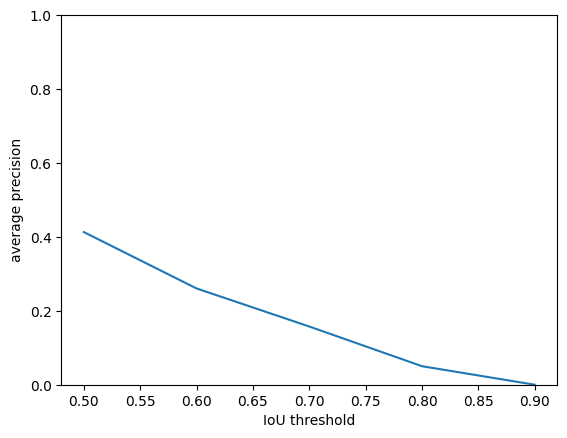

In [13]:
def get_masks_unet(output, cell_threshold=0, min_size=30):
  """ create masks using NOT CELL probability and CELL probability

  min_size: minimum number of pixels in the masks
  """

  cells = (output[1] - output[0]) > cell_threshold
  selem = generate_binary_structure(cells.ndim, connectivity=1)
  masks, nlabels = label(cells, selem)
  shape0 = masks.shape
  _,masks = np.unique(masks, return_inverse=True)
  masks = np.reshape(masks, shape0)
  # fill holes and remove small masks
  masks = fill_holes_and_remove_small_masks(masks, min_size=min_size)

  return masks.astype(np.uint16)


# Run the model
net.eval()
# (depending on GPU capacity you may need to run this in a loop)
val_padded, slices = pad_image_ND(val_data, 8)
val_torch = torch.from_numpy(val_padded).to(device)
out = net(val_torch)
# compute CELL / NOT CELL probability
labels = out[slices].detach().cpu().numpy()

# create masks from probabilities
cell_threshold = 2.5
masks = [get_masks_unet(lbl, cell_threshold=cell_threshold) for lbl in labels]

# (note this function expects multiple masks)
iou_threshold = np.arange(0.5, 1, 0.1)
ap = average_precision(val_masks, masks, threshold=iou_threshold)[0]

# plot results
print(ap[:, 0].mean(axis=0))
plt.plot(iou_threshold, ap.mean(axis=0))
plt.xlabel('IoU threshold')
plt.ylabel('average precision')
plt.ylim([0, 1])
plt.show()

Once you choose a threshold, you'll want to use it on your test images.

0.5627842


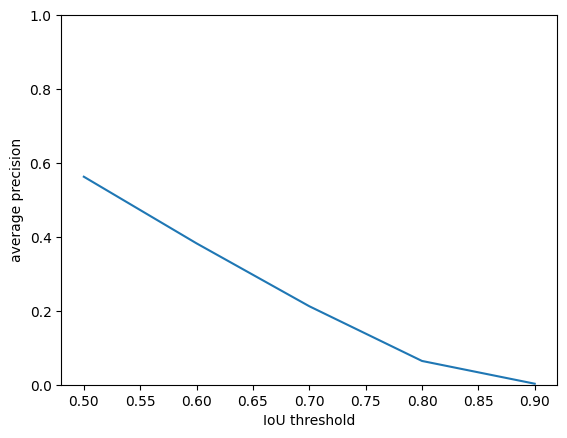

In [14]:
net.eval()
# (depending on GPU capacity you may need to run this in a loop)
test_padded, slices = pad_image_ND(imgs_test, 8)
test_torch = torch.from_numpy(test_padded).to(device)
out = net(test_torch)
# compute CELL / NOT CELL probability
labels = out[slices].detach().cpu().numpy()

# create masks from probabilities
masks = [get_masks_unet(lbl, cell_threshold=cell_threshold) for lbl in labels]

# (note this function expects multiple masks)
iou_threshold = np.arange(0.5, 1, 0.1)
ap = average_precision(masks_test, masks, threshold=iou_threshold)[0]

# plot results
print(ap[:,0].mean(axis=0))
plt.plot(iou_threshold, ap.mean(axis=0))
plt.xlabel('IoU threshold')
plt.ylabel('average precision')
plt.ylim([0, 1])
plt.show()

What kinds of errors is the network making?

U-nets with this type of prediction (CELL/NOT CELL) typically overmerge cells. You may see some examples below. In the text at the beginning, ways to avoid this problem are discussed and also one instance (distance to boundary) is implemented in the cellpose repository. 

You can also compare your results to cellpose using the web interface at [www.cellpose.org](https://www.cellpose.org).

Below you can see that we are plotting the ground truth masks (the true masks) and the masks that the algorithm predicted. It may be sort of hard to compare the masks in a jupyter-notebook. One useful tool to visualize imaging data is [napari](https://www.napari.org). You can try running it on your local computer and visualizing your predictions overlaid on the original images.

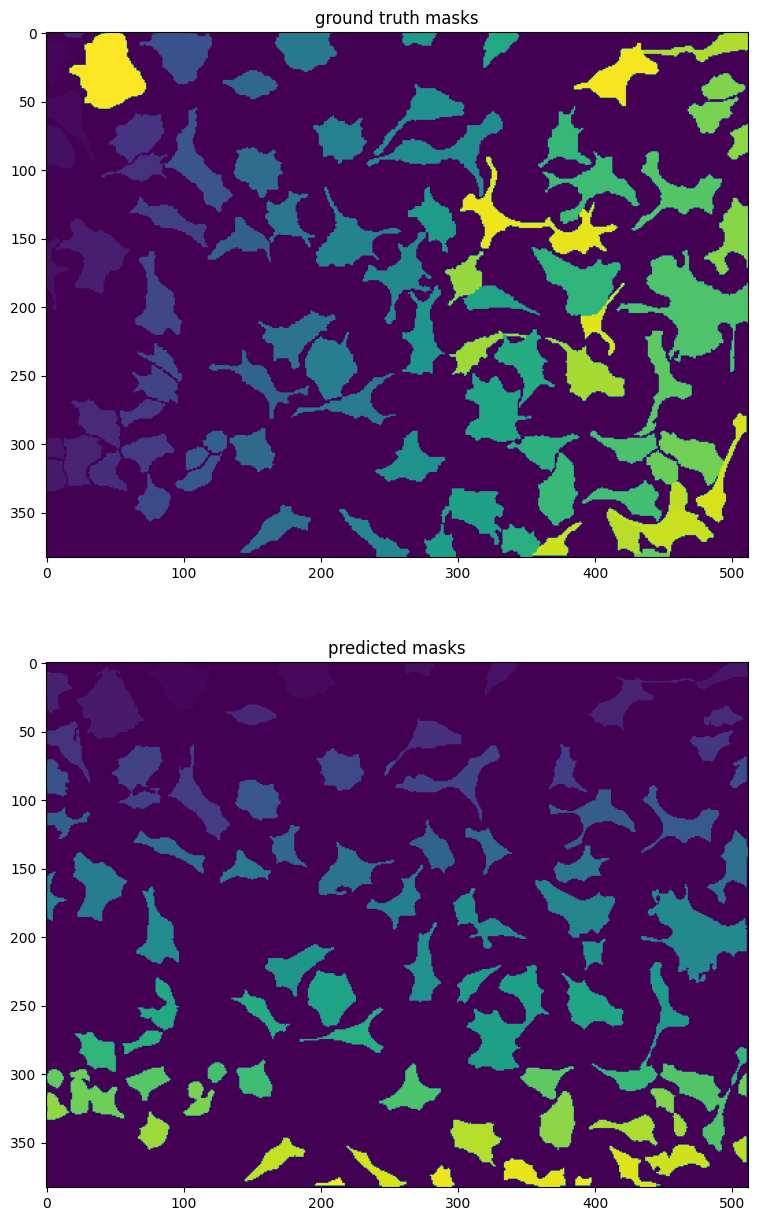

In [15]:
plt.figure(figsize=(10, 15))
plt.subplot(2, 1, 1)
plt.imshow(masks_test[0])
plt.title('ground truth masks')
plt.subplot(2, 1, 2)
plt.imshow(masks[0])
plt.title('predicted masks')
plt.show()

# Analysis of neuronal activity in the brain

This is a calcium imaging recording in mouse visual cortex taken at an imaging rate of 10Hz. There are 4500 frames of size 325 x 556 pixels each.

Let's load the data and try to find some cells!

In [16]:
# @title Download and load the data.
from tifffile import imread

fname = "gt1.tif"
url = "https://www.suite2p.org/test_data/gt1.tif" # This URL does not exist.

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

data = imread(fname)
print(f"imaging data of shape: {data.shape}")
n_time, Ly, Lx = data.shape

imaging data of shape: (4500, 325, 556)


## Finding cells

This process can be improved by adding training data to the model and/or improving the type of filtering done by the image and/or by finding cells using temporal information. We've used our previously trained network to find some cells as a starting point.

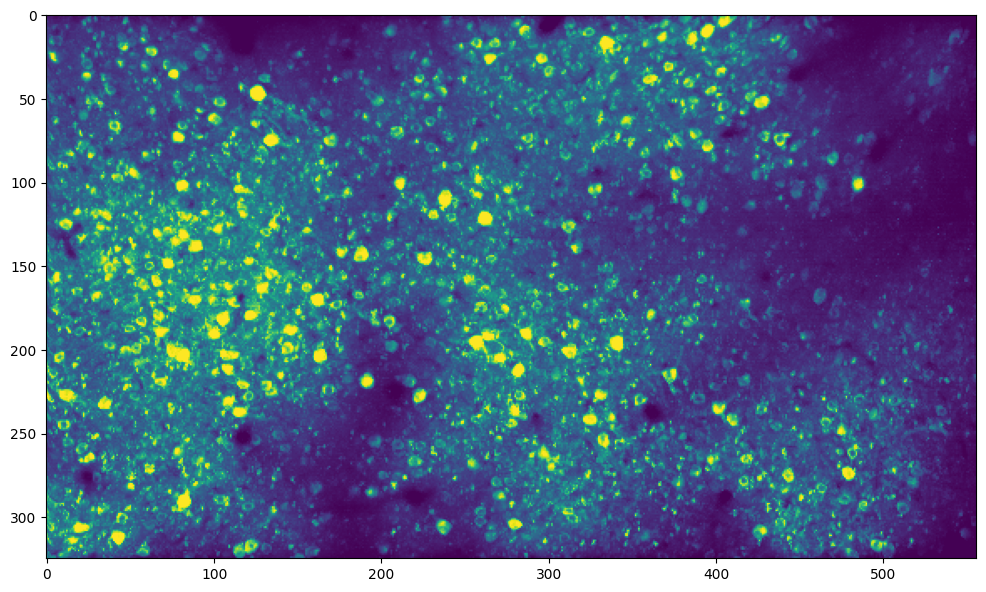

In [17]:
# plot max image across time
max_img = normalize99(data.max(axis=0))
plt.figure(figsize=(12, 8))
plt.imshow(max_img, vmin=0, vmax=1)
plt.show()

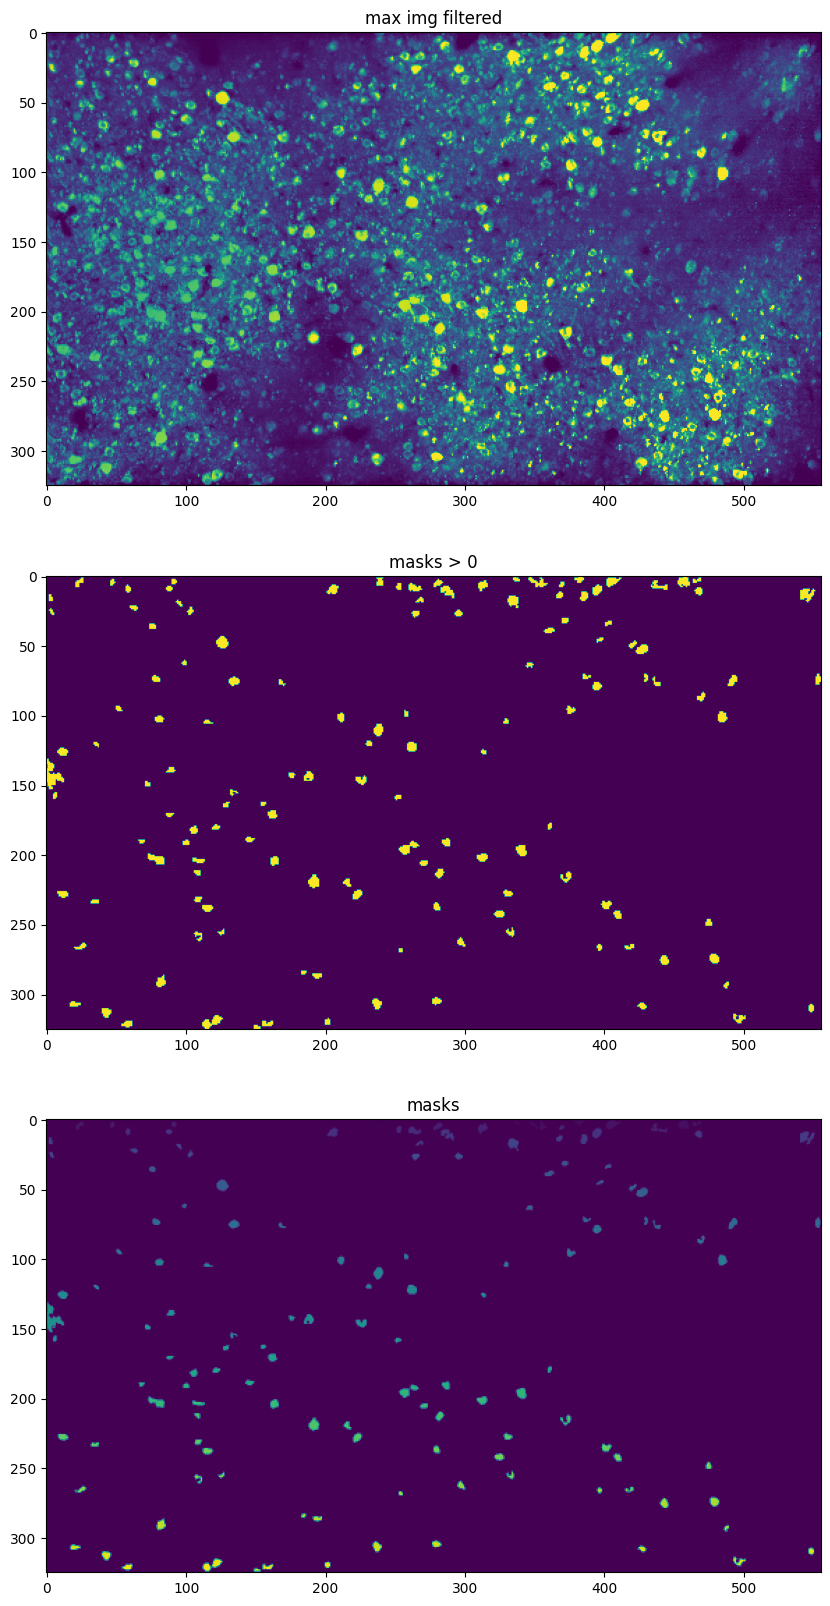

In [18]:
# normalize intensity across image
max_img_filtered = max_img.copy() / gaussian_filter(max_img, 100)
# high pass filter
max_img_filtered = max_img_filtered - gaussian_filter(max_img, 10)
max_img_filtered = normalize99(max_img_filtered)
## take threshold of image to find cells
# masks = get_masks_unet(np.stack((1 - max_img, max_img), axis=0), cell_threshold=0.3)

### can try running network trained above (on unfiltered or filtered)
net.eval()
# resize larger because cells are smaller here
max_img_large = cv2.resize(max_img_filtered, (Lx*2, Ly*2))
max_img_2chan = np.stack((max_img_large, np.zeros_like(max_img_large)), axis=0)
# run network
img_padded, slices = pad_image_ND(max_img_2chan, 8)
img_torch = torch.from_numpy(img_padded).to(device).unsqueeze(0)  # also need to add a first dimension
out = net(img_torch)
labels = out[0][slices].detach().cpu()

# THIS CELL_THRESHOLD NEEDS TO BE SET BY HAND! IT VARIES FROM NETWORK TO NETWORK
masks = get_masks_unet(labels, cell_threshold=3.5, min_size=30)
masks = cv2.resize(masks, (Lx, Ly), cv2.INTER_NEAREST)

plt.figure(figsize=(12, 20))
plt.subplot(3, 1, 1)
plt.imshow(max_img_filtered, vmin=0, vmax=1)
plt.title('max img filtered')
plt.subplot(3, 1, 2)
plt.imshow(masks > 0)
plt.title('masks > 0')
plt.subplot(3, 1, 3)
plt.imshow(masks)
plt.title('masks')
plt.show()

## Neural activity

We can use these masks to find neural activity:

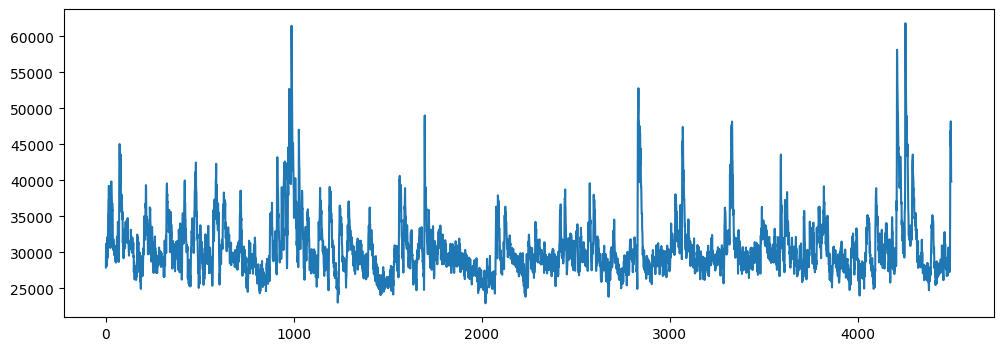

In [19]:
n_cells = masks.max()
fluorescence = np.zeros((n_cells, n_time), np.float32)
for n in range(n_cells):
  fluorescence[n] = data[:, masks==(n + 1)].sum(axis=1)

plt.figure(figsize=(12, 4))
plt.plot(fluorescence[0])
plt.show()

## Denoising

There may be some noise in the imaging trace, can we correct it by building a denoising network?

Take the u-net architecture from above and modify it to take as inputs multiple sequential frames with the middle frame left out, and predict the middle frame. Check out this [paper](https://www.biorxiv.org/content/10.1101/2020.10.15.341602v2.full) from the Allen Institute for more guidance.

Note you can use this strategy on a variety of datasets with spatial and temporal structure, such as movies taken in low light conditions.

You could also try this approach on neural data without spatial structure (but you would have to replace the convolutions with fully connected layers).